In [23]:
import warnings
warnings.filterwarnings('ignore') 

In [24]:
import pandas as pd

In [25]:
df = pd.read_csv('cleaned_dataset_updated_csv.csv')

In [26]:
df.head()

,code,status,is_valid,is_active,has_completed,candidate_signed_date,stipend_first,stipend_second,establishment_code,candidate_name,...,Contract Stipend,Prescribed Stipend,Eligible No. of Days,Unauthorized / Leave Without Pay (No. of Days),Stipend Payable,Additional Amount,Total Amount Payable,Dbt Amount,Dbt Payment Status,Month / Year
0,CN012122325,termination_approved,0.0,0.0,0.0,1/18/2021 0:00,11000.0,12000.0,E01210600066,ROHIT KUMAR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CN012115741,termination_approved,0.0,0.0,0.0,1/13/2021 0:00,11000.0,12000.0,E12200600008,ASHISH KUMAR,...,11000.0,6000.0,24.0,1.0,8161.0,210.0,8371.0,0.0,In-Progress,1/1/2021 0:00
2,CN012115741,termination_approved,0.0,0.0,0.0,1/13/2021 0:00,11000.0,12000.0,E12200600008,ASHISH KUMAR,...,11000.0,6000.0,28.0,2.0,10214.0,286.0,10500.0,0.0,In-Progress,2/1/2021 0:00
3,CN012115741,termination_approved,0.0,0.0,0.0,1/13/2021 0:00,11000.0,12000.0,E12200600008,ASHISH KUMAR,...,11000.0,6000.0,31.0,2.0,10290.0,210.0,10500.0,0.0,In-Progress,3/1/2021 0:00
4,CN012115741,termination_approved,0.0,0.0,0.0,1/13/2021 0:00,11000.0,12000.0,E12200600008,ASHISH KUMAR,...,11000.0,6000.0,30.0,4.0,9533.0,234.0,9767.0,0.0,In-Progress,4/1/2021 0:00


In [27]:
df.shape

(1177, 52)

In [28]:
# Fill missing numerical values with mean
num_cols = ['stipend_first', 'stipend_second', 'Contract Stipend', 'Prescribed Stipend']
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Fill missing categorical values with 'Unknown'
cat_cols = ['QualificationType', 'Gender', 'Insurance Taken']
df[cat_cols] = df[cat_cols].fillna('Unknown')

# Drop rows with too many missing values if necessary
df = df.dropna(thresh=len(df.columns) - 5)  # Drop rows with more than 5 missing values


In [29]:
# Retain candidate identifier for traceability
candidate_identifier = df[['Candidate Code']]  # Keep this separate for mapping predictions later

# Drop irrelevant columns
irrelevant_cols = [
    'Candidate Name', 'cand_parent_name', 'Complete address',
    'Father/Mother/Spouse Name', 'Mobile Number', 'onJobTrainingLocation_address'
]
df = df.drop(columns=irrelevant_cols)

# Retain relevant features
relevant_features = [
    'Candidate Code', 'is_active', 'has_completed', 'stipend_first', 'stipend_second',
    'Contract Stipend', 'Prescribed Stipend', 'on_job_training_period_from',
    'on_job_training_period_to', 'Eligible No. of Days', 'Unauthorized / Leave Without Pay (No. of Days)',
    'QualificationType', 'Gender', 'Insurance Taken'
]
df = df[relevant_features]


In [30]:
import numpy as np

# Convert dates to datetime
df['on_job_training_period_from'] = pd.to_datetime(df['on_job_training_period_from'], errors='coerce')
df['on_job_training_period_to'] = pd.to_datetime(df['on_job_training_period_to'], errors='coerce')

# Calculate program duration in days
df['Program_Duration'] = (df['on_job_training_period_to'] - df['on_job_training_period_from']).dt.days

# Calculate stipend gap
df['Stipend_Gap'] = df['Prescribed Stipend'] - df['stipend_first']

# Define target variable (Dropout)
df['Dropout'] = np.where((df['is_active'] == 0) & (df['has_completed'] == 0), 1, 0)

# Drop columns used to create target or unnecessary now
df = df.drop(columns=['is_active', 'has_completed', 'on_job_training_period_from', 'on_job_training_period_to'])


In [31]:
# Encode categorical features
df = pd.get_dummies(df, columns=['QualificationType', 'Gender', 'Insurance Taken'], drop_first=True)


In [32]:
from sklearn.preprocessing import StandardScaler

# List of numerical features to scale
num_cols = ['stipend_first', 'stipend_second', 'Contract Stipend', 'Prescribed Stipend', 'Program_Duration', 'Stipend_Gap']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])



In [33]:
# Keep Candidate Code separate for later use
candidate_code = df['Candidate Code']
df = df.drop(columns=['Candidate Code'])  # Remove it from training features


In [34]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(columns=['Dropout'])  # Features
y = df['Dropout']  # Target

In [41]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

In [42]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import classification_report, roc_auc_score

# # Train Decision Tree Classifier
# model = DecisionTreeClassifier(random_state=50)
# model.fit(X_train, y_train)

# # Predictions
# y_pred = model.predict(X_test)
# y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# # Evaluate using classification metrics
# print(classification_report(y_test, y_pred))
# print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


DecisionTreeClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        80
           1       0.89      0.92      0.90       107

    accuracy                           0.89       187
   macro avg       0.89      0.88      0.88       187
weighted avg       0.89      0.89      0.89       187

Confusion Matrix:
[[68 12]
 [ 9 98]]


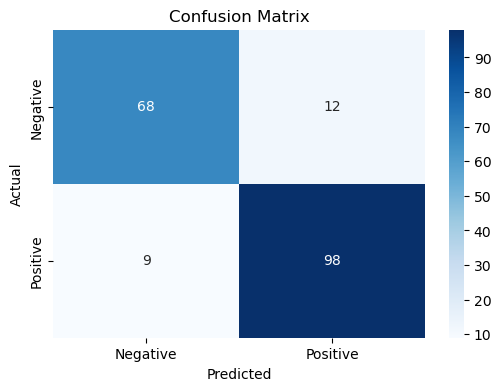

Accuracy: 0.89
Precision: 0.89
Recall: 0.92
F1-Score: 0.90
ROC-AUC Score: 0.93


In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# Train Decision Tree Classifier
model = DecisionTreeClassifier(random_state=50)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Evaluate using classification metrics
print("DecisionTreeClassifier")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Compute individual metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro' or 'micro' for multiclass
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")


Logistic Regression:
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        80
           1       0.88      0.95      0.91       107

    accuracy                           0.90       187
   macro avg       0.90      0.89      0.89       187
weighted avg       0.90      0.90      0.90       187

Confusion Matrix:
[[ 66  14]
 [  5 102]]


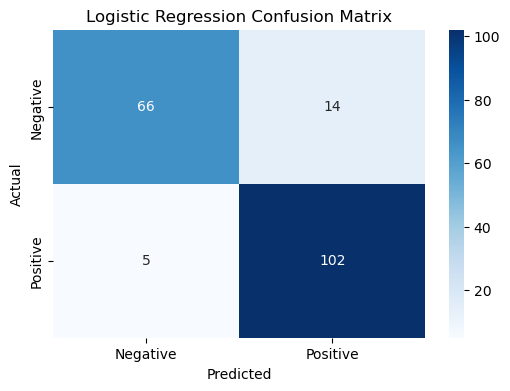

Accuracy: 0.90
Precision: 0.88
Recall: 0.95
F1-Score: 0.91
ROC-AUC Score: 0.96


In [44]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression Model
log_model = LogisticRegression(random_state=50)
log_model.fit(X_train, y_train)

# Predictions
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Logistic Regression:")
print("Classification Report:")
print(classification_report(y_test, y_pred_log))

# Confusion Matrix
cm_log = confusion_matrix(y_test, y_pred_log)
print("Confusion Matrix:")
print(cm_log)

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Compute individual metrics
accuracy_log = accuracy_score(y_test, y_pred_log)
precision_log = precision_score(y_test, y_pred_log, average='binary')
recall_log = recall_score(y_test, y_pred_log, average='binary')
f1_log = f1_score(y_test, y_pred_log, average='binary')
roc_auc_log = roc_auc_score(y_test, y_proba_log)

print(f"Accuracy: {accuracy_log:.2f}")
print(f"Precision: {precision_log:.2f}")
print(f"Recall: {recall_log:.2f}")
print(f"F1-Score: {f1_log:.2f}")
print(f"ROC-AUC Score: {roc_auc_log:.2f}")


Naive Bayes:
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.69      0.76        80
           1       0.80      0.92      0.85       107

    accuracy                           0.82       187
   macro avg       0.83      0.80      0.81       187
weighted avg       0.82      0.82      0.81       187

Confusion Matrix:
[[55 25]
 [ 9 98]]


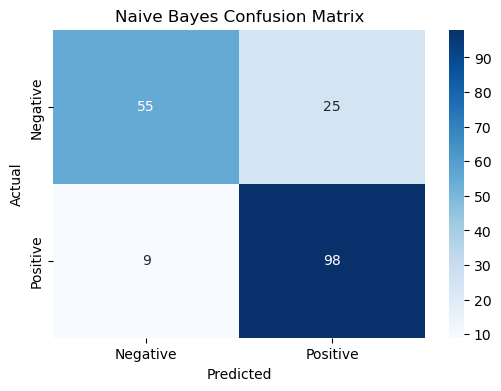

Accuracy: 0.82
Precision: 0.80
Recall: 0.92
F1-Score: 0.85
ROC-AUC Score: 0.94


In [45]:
from sklearn.naive_bayes import GaussianNB

# Train Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred_nb = nb_model.predict(X_test)
y_proba_nb = nb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Naive Bayes:")
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
print("Confusion Matrix:")
print(cm_nb)

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

# Compute individual metrics
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='binary')
recall_nb = recall_score(y_test, y_pred_nb, average='binary')
f1_nb = f1_score(y_test, y_pred_nb, average='binary')
roc_auc_nb = roc_auc_score(y_test, y_proba_nb)

print(f"Accuracy: {accuracy_nb:.2f}")
print(f"Precision: {precision_nb:.2f}")
print(f"Recall: {recall_nb:.2f}")
print(f"F1-Score: {f1_nb:.2f}")
print(f"ROC-AUC Score: {roc_auc_nb:.2f}")


Linear Regression:
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.80      0.87        80
           1       0.87      0.97      0.92       107

    accuracy                           0.90       187
   macro avg       0.91      0.89      0.89       187
weighted avg       0.90      0.90      0.90       187

Confusion Matrix:
[[ 64  16]
 [  3 104]]


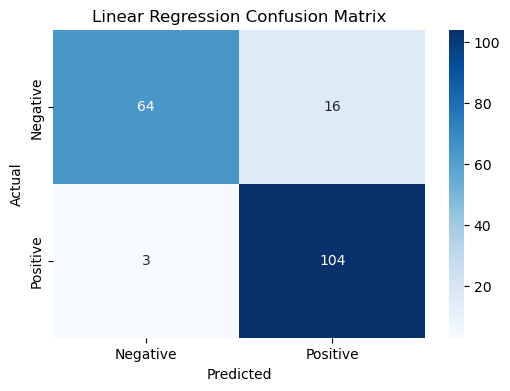

Accuracy: 0.90
Precision: 0.87
Recall: 0.97
F1-Score: 0.92
ROC-AUC Score: 0.97


In [46]:
from sklearn.linear_model import LinearRegression

# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions (convert regression output to binary classification)
y_proba_lr = lr_model.predict(X_test)
y_pred_lr = (y_proba_lr >= 0.5).astype(int)  # Threshold at 0.5

# Evaluation
print("Linear Regression:")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:")
print(cm_lr)

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Linear Regression Confusion Matrix')
plt.show()

# Compute individual metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='binary')
recall_lr = recall_score(y_test, y_pred_lr, average='binary')
f1_lr = f1_score(y_test, y_pred_lr, average='binary')
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"Accuracy: {accuracy_lr:.2f}")
print(f"Precision: {precision_lr:.2f}")
print(f"Recall: {recall_lr:.2f}")
print(f"F1-Score: {f1_lr:.2f}")
print(f"ROC-AUC Score: {roc_auc_lr:.2f}")


Random Forest Classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88        80
           1       0.89      0.95      0.92       107

    accuracy                           0.90       187
   macro avg       0.91      0.90      0.90       187
weighted avg       0.91      0.90      0.90       187

Confusion Matrix:
[[ 67  13]
 [  5 102]]


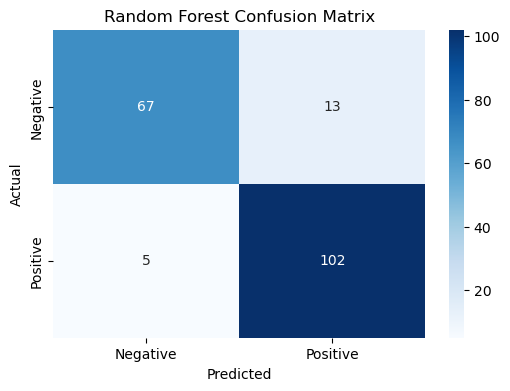

Accuracy: 0.90
Precision: 0.89
Recall: 0.95
F1-Score: 0.92
ROC-AUC Score: 0.96


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
y_pred_rf = (y_proba_rf >= 0.5).astype(int)  # Threshold at 0.5

# Evaluation
print("Random Forest Classifier:")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(cm_rf)

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Compute individual metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='binary')
recall_rf = recall_score(y_test, y_pred_rf, average='binary')
f1_rf = f1_score(y_test, y_pred_rf, average='binary')
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Precision: {precision_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")
print(f"F1-Score: {f1_rf:.2f}")
print(f"ROC-AUC Score: {roc_auc_rf:.2f}")


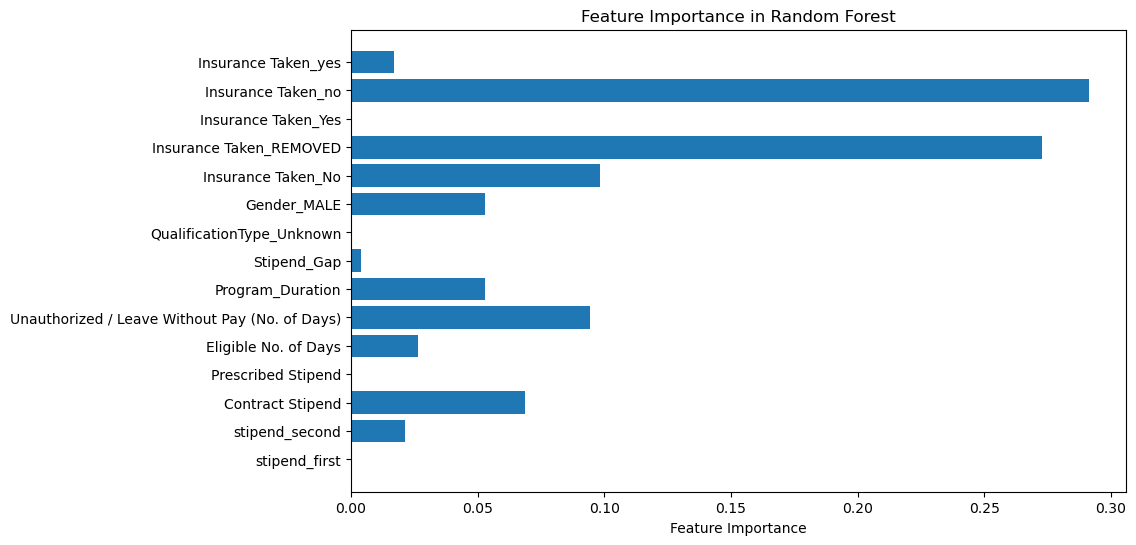

In [47]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.show()


In [17]:
# Add predictions to a DataFrame with Candidate Code
X_test_with_code = X_test.copy()
X_test_with_code['Candidate Code'] = candidate_code[X_test.index]
X_test_with_code['Predicted Dropout'] = y_pred
X_test_with_code['Dropout Probability'] = y_proba

# Save the results to a CSV file
X_test_with_code.to_csv('predictions_with_candidate_code.csv', index=False)


In [18]:
import joblib

# Save the model
joblib.dump(model, 'random_forest_model.pkl')

# Load the model later
loaded_model = joblib.load('random_forest_model.pkl')
